In [2]:
!pip install shap

## **Project: Car Evaluation Model**
- **Source**: M. Bohanec, V. Rajkovič (1988). Knowledge acquisition and explanation for multi-attribute decision making. Published in 8th Intl Workshop on Expert Systems and their Applications, Avignon, France
- **URL**: https://archive.ics.uci.edu/dataset/19/car+evaluation
- **Date**: 17/03/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Basics ---------------------------------------------------------------
import logging
import pickle
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder
)
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
import shap

# Configuración del registro
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
df_raw = pd.read_csv('/content/car.csv', header=None)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1728 non-null   object
 1   1       1728 non-null   object
 2   2       1728 non-null   object
 3   3       1728 non-null   object
 4   4       1728 non-null   object
 5   5       1728 non-null   object
 6   6       1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [6]:
df_raw.sample(10, random_state=2025)

,0,1,2,3,4,5,6
360,vhigh,low,3,4,small,low,unacc
1016,med,high,3,4,big,high,acc
447,high,vhigh,2,4,big,low,unacc
272,vhigh,med,4,2,small,high,unacc
554,high,high,2,4,med,high,acc
1627,low,low,2,2,big,med,unacc
1293,med,low,5more,more,big,low,unacc
1702,low,low,5more,2,small,med,unacc
1503,low,high,5more,more,small,low,unacc
652,high,med,2,2,med,med,unacc


##### **Data dictionary**
|Name|Description|Type|Units|
|----|-----------|----|-----|
|buying|buying price|Category|vhigh, high, med, low|
|maint|price of the maintenance|Category|vhigh, high, med, low|
|doors|number of doors|Category|2, 3, 4, 5more|
|persons|capacity in terms of persons to carry|Category|2, 4, more|
|lug_boot|the size of luggage boot|Category|small, med, big|
|safety|estimated safety of the car|Category|low, med, high|
|class|evaulation level|Category|unacc, acc, good, vgood|

In [3]:
df_baking = df_raw.copy()
df_baking.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df_baking = df_baking.astype(
    {'buying': 'category',
     'maint': 'category',
     'doors': 'category',
     'persons': 'category',
     'lug_boot': 'category',
     'safety': 'category',
     'class': 'category'}
)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   buying    1728 non-null   category
 1   maint     1728 non-null   category
 2   doors     1728 non-null   category
 3   persons   1728 non-null   category
 4   lug_boot  1728 non-null   category
 5   safety    1728 non-null   category
 6   class     1728 non-null   category
dtypes: category(7)
memory usage: 13.1 KB


In [4]:
df_train, df_test = train_test_split(
    df, test_size=0.2,
    stratify=df['class'],
    random_state=2024
)
df_train, df_val = train_test_split(
    df_train, test_size=0.2,
    stratify=df_train['class'],
    random_state=2024
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((1105, 7), (277, 7), (346, 7))

In [9]:
df_train.describe(include='category').T

,count,unique,top,freq
buying,1105,4,low,285
maint,1105,4,med,284
doors,1105,4,5more,287
persons,1105,3,4,380
lug_boot,1105,3,med,370
safety,1105,3,low,372
class,1105,4,unacc,774


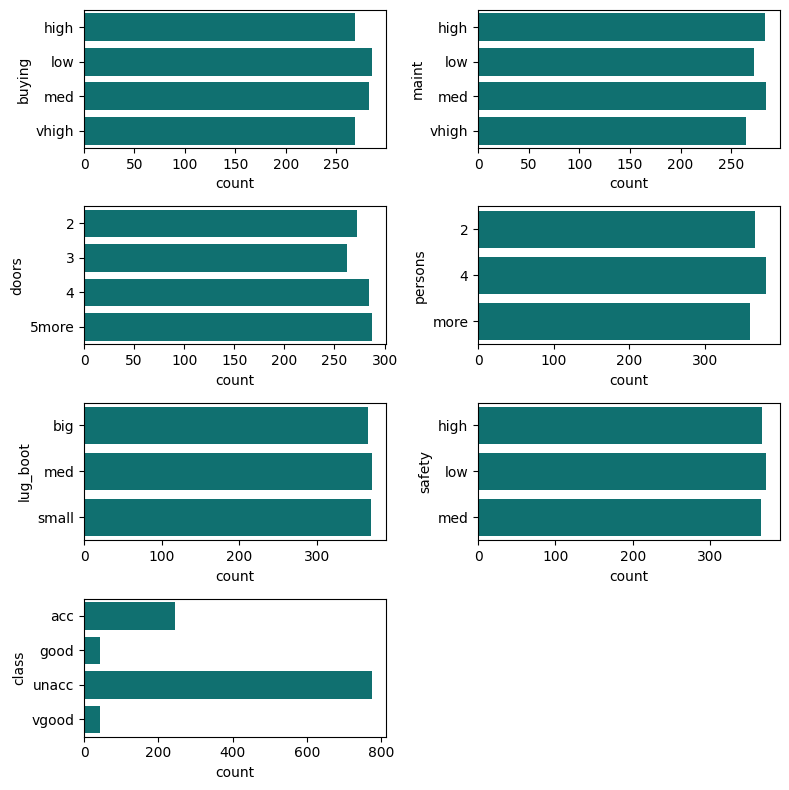

In [10]:
# Univariate analysis
fig, ax = plt.subplots(4,2, figsize=(8,8))
axes = ax.flatten()
for i, ax in enumerate(axes):
    if i<df_train.shape[1]:
        sns.countplot(df_train.iloc[:,i], color='Teal', ax=ax)
    else:
        axes[-1].remove()
plt.tight_layout()
plt.show()

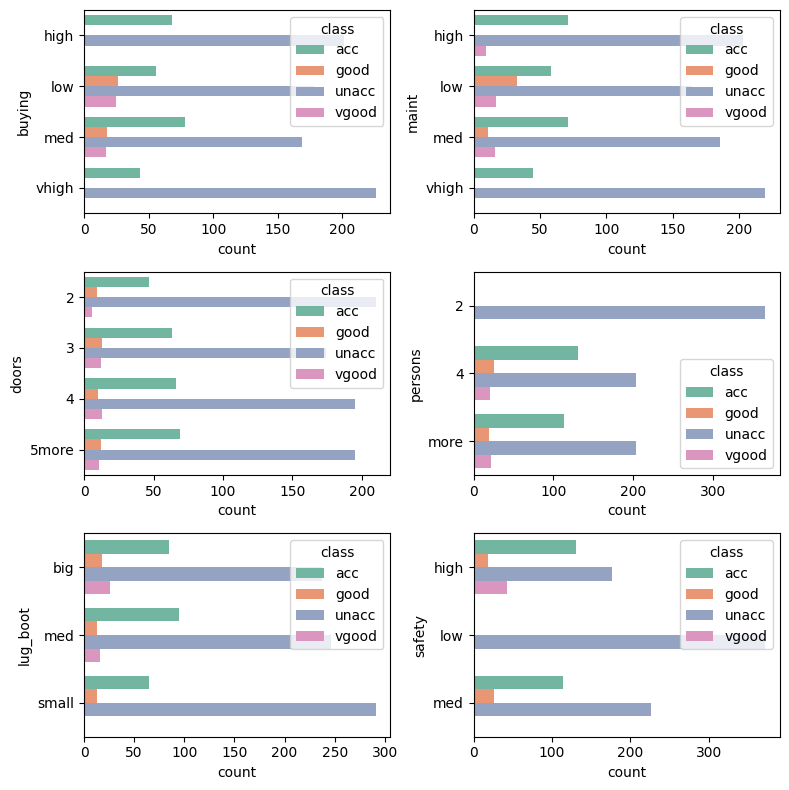

In [11]:
# Bivariate analysis
fig, ax = plt.subplots(3,2, figsize=(8,8))
axes = ax.flatten()
cols = df_train.columns.to_list()
for i, ax in enumerate(axes):
    if i<df_train.shape[1]:
        sns.countplot(df_train, y=cols[i], hue=cols[-1], ax=ax, palette='Set2')
plt.tight_layout()
plt.show()

In [5]:
X_train = df_train.drop(columns=['class'])
y_train = df_train['class']
X_val = df_val.drop(columns=['class'])
y_val = df_val['class']
X_test = df_test.drop(columns=['class'])
y_test = df_test['class']

In [6]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [7]:
clf_rforest_p = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('rforest', RandomForestClassifier(class_weight='balanced'))
])
clf_rforest_p

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('rforest', RandomForestClassifier(class_weight='balanced'))])

In [8]:
clf_rforest_p.fit(X_train, y_train_enc)
y_hat_val = clf_rforest_p.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val_enc, y_hat_val)}')
print(f'Kappa: {cohen_kappa_score(y_val_enc, y_hat_val)}')

Accuracy: 0.9711191335740073
Kappa: 0.937353348599214


In [9]:
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        'rforest__n_estimators': [10, 20, 30, 50, 100, 200, 300],
        'rforest__max_depth': [None, 2,3,4,5,6,7],
    },
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

In [10]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': None, 'rforest__n_estimators': 200}

Accuracy: 0.96
Kappa: 0.91
              precision    recall  f1-score   support

         acc       0.88      0.95      0.91        62
        good       1.00      0.73      0.84        11
       unacc       0.98      0.97      0.98       194
       vgood       1.00      1.00      1.00        10

    accuracy                           0.96       277
   macro avg       0.97      0.91      0.93       277
weighted avg       0.96      0.96      0.96       277



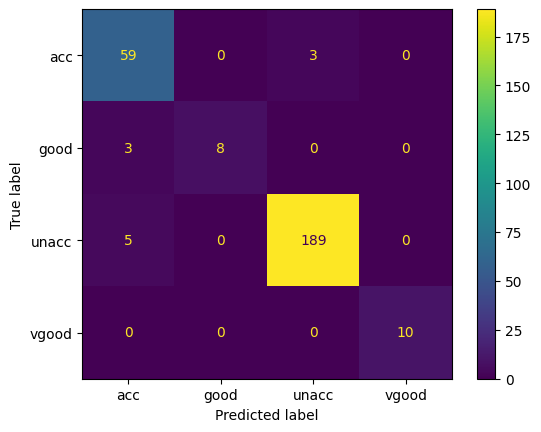

In [11]:
y_hat_val = clf_rforest_cv.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val_enc, y_hat_val):.2f}')
print(f'Kappa: {cohen_kappa_score(y_val_enc, y_hat_val):.2f}')
print(classification_report(y_val_enc, y_hat_val, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels=label_encoder.classes_)
plt.show()

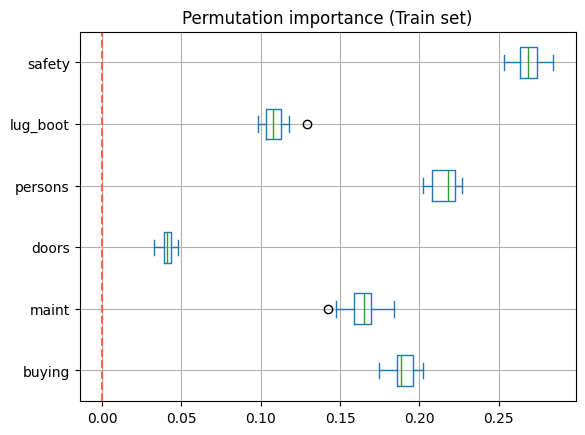

In [12]:
importance = permutation_importance(
    clf_rforest_cv, X_train, y_train_enc,
    n_repeats=25, random_state=2024
)
importance_df = pd.DataFrame(
    importance.importances.T,
    columns=X_train.columns
)

ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--', c='Tomato')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

In [21]:
X_encoder = clf_rforest_cv.best_estimator_['onehot'].fit_transform(X_train)
features = clf_rforest_cv.best_estimator_['onehot'].get_feature_names_out()
features

array(['buying_high', 'buying_low', 'buying_med', 'buying_vhigh',
       'maint_high', 'maint_low', 'maint_med', 'maint_vhigh', 'doors_2',
       'doors_3', 'doors_4', 'doors_5more', 'persons_2', 'persons_4',
       'persons_more', 'lug_boot_big', 'lug_boot_med', 'lug_boot_small',
       'safety_high', 'safety_low', 'safety_med'], dtype=object)

In [23]:
X_encoder.toarray()

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [25]:
p = pd.DataFrame(X_encoder.toarray(), columns=features)
p

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1101,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1102,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1103,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [26]:
best_model = clf_rforest_cv.best_estimator_['rforest'].fit(X_encoder, y_train_enc)
shap_values = shap.TreeExplainer(best_model).shap_values(p)

<Figure size 640x480 with 0 Axes>

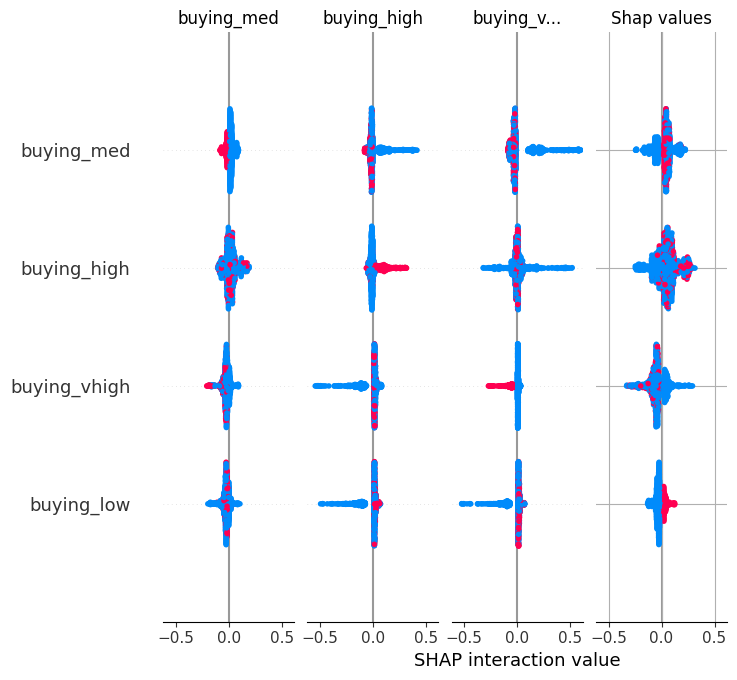

In [30]:
plt.figure()
shap.summary_plot(shap_values, p, plot_type='bar', show=False)
plt.title('Shap values')
plt.grid(True)
plt.show()

In [13]:
X_encoded = clf_rforest_cv.best_estimator_['onehot'].fit_transform(X_train)
features = clf_rforest_cv.best_estimator_['onehot'].get_feature_names_out()
best_model = clf_rforest_cv.best_estimator_['rforest'].fit(X_encoded, y_train_enc)

# calculate the Shap values
shap_values = shap.TreeExplainer(best_model).shap_values(pd.DataFrame(X_encoded.toarray(),columns=features))

In [15]:
shap_values

array([[[-0.02029832,  0.01218009, -0.0043072 ,  0.01242543],
        [-0.0360719 ,  0.04243116, -0.0492813 ,  0.04292203],
        [-0.00412202, -0.00720872,  0.01477852, -0.00344778],
        ...,
        [ 0.02165669,  0.01039384, -0.09422895,  0.06217841],
        [ 0.03330236,  0.01039764, -0.05346714,  0.00976714],
        [-0.03429347, -0.0104665 ,  0.01373907,  0.0310209 ]],

       [[-0.01018473,  0.01085026, -0.00812286,  0.00745733],
        [ 0.02823284, -0.03194734,  0.01937187, -0.01565737],
        [-0.00052339,  0.00664162, -0.01117184,  0.0050536 ],
        ...,
        [-0.04225068, -0.05023901,  0.19845074, -0.10596106],
        [-0.1995483 , -0.13784834,  0.40997868, -0.07258204],
        [-0.09677733, -0.04831583,  0.1233539 ,  0.02173925]],

       [[-0.00312456,  0.0051917 , -0.0080484 ,  0.00598126],
        [ 0.01517311, -0.02532641,  0.03737035, -0.02721705],
        [-0.00430081, -0.01147341,  0.03063178, -0.01485757],
        ...,
        [-0.06502586,  0.01

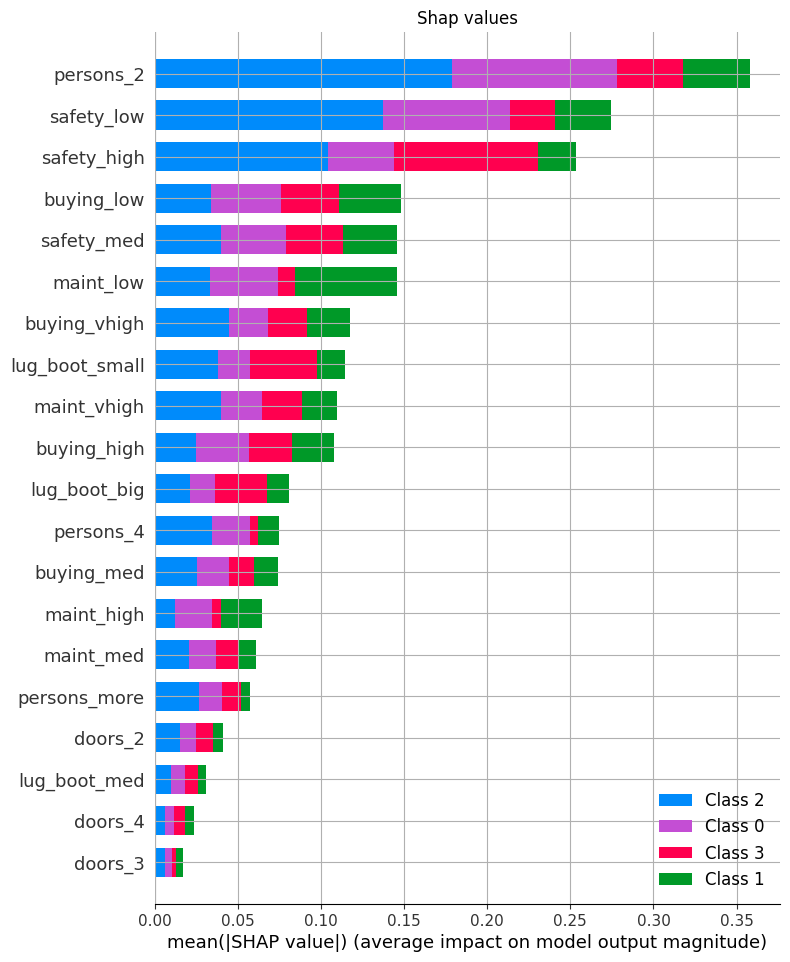

In [14]:
plt.figure()
shap.summary_plot(
    shap_values, pd.DataFrame(X_encoded.toarray(),columns=features),
    plot_type='bar', show=False)
plt.title('Shap values')
plt.grid(True)
plt.show()

In [33]:
!pip freeze

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.13
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.3.10.0.29.26
astunparse==1.6.3
atpublic==4.1.0
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.40.0
bigquery-magics==0.8.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.0
blosc2==3.2.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.

In [34]:
!pip install shap==0.47.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0
